# Fine Tuning model for instructions

load openai's medium model for better results

In [1]:
import torch
import tiktoken
import myllm.gpt as gpt
import myllm.util
import myllm.data as data

In [2]:
# Initialize model
device = torch.device("cpu")
tokenizer = tiktoken.get_encoding('gpt2')

gpt_config = myllm.util.gpt_config("gpt2-medium")

# openai runs with qkv bias
gpt_config.update({'qkv_bias': True})
model = gpt.GPTModel(gpt_config)

In [3]:
# load open weights
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="355M", models_dir="gpt2"
)
print(settings)
myllm.util.load_openai_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe
{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [4]:
#data loaders and data
train_data, val_data, test_data = data.split_instruction_data("data/instruction-data.json")

In [5]:
print(val_data)

[{'instruction': "Convert the active sentence to passive: 'The chef cooks the meal every day.'", 'input': '', 'output': 'The meal is cooked by the chef every day.'}, {'instruction': 'Classify an input string as either a noun or a verb.', 'input': 'Dance', 'output': "'Dance' can be classified as a verb."}, {'instruction': 'Rewrite the sentence using a metaphor.', 'input': 'The book is very interesting.', 'output': 'The book is a page-turner.'}, {'instruction': 'Generate a question with the keyword “bacteria”', 'input': '', 'output': 'How do bacteria affect human health?'}, {'instruction': "What is the past participle of 'run'?", 'input': '', 'output': "The past participle of 'run' is 'run'."}, {'instruction': "Provide a synonym for 'quick'.", 'input': '', 'output': "A synonym for 'quick' is 'rapid'."}, {'instruction': 'Give an example of a metaphor.', 'input': '', 'output': "An example of a metaphor is saying, 'Time is a thief,' which suggests that time, like a thief, can take away life

## Assets pretrained performance

using openai 355M model, understand the loss 

In [6]:


torch.manual_seed(123)
input_text = data.format_instruction_input(val_data[0])
print(input_text)

Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [16]:
token_ids = model.generate(
    idx=myllm.util.text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=gpt_config["context_length"],
    eos_id=data.PAD_TOKEN_ID,
    temperature=1.4
)

generated_text = myllm.util.token_ids_to_text(token_ids, tokenizer)
repsonse_text = generated_text[len(input_text):].strip()
print(repsonse_text)

21 snakes pit 6 and 19 point 17 6, 7

 27, 3-ratgame. 27, 4, 21.
### Response: 21, 21
937


In [8]:
train_loader, val_loader, test_loader = data.create_instruction_data_loaders(
    train_data, val_data, test_data, batch_size=8, num_workers=0, 
    device=device, tokenizer=tokenizer 
)
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = myllm.util.calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = myllm.util.calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

print("Training loss", train_loss)
print("Val loss", val_loss)

Training loss 10.548917770385742
Val loss 10.50520076751709


## Fine tuning

In [9]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, token_seen = myllm.util.train_model_simple(
    model=model, train_loader=train_loader, val_loader=val_loader,
    optimizer=optimizer, device=device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context=data.format_instruction_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
exec_time = (end_time - start_time) / 60

print(f"Training co,pleted in {exec_time:.2f} minutes")

Ep 1 (step 000000): Train loss  6.639Val loss  6.620
Ep 1 (step 000005): Train loss  3.970Val loss  3.963
Ep 1 (step 000010): Train loss  3.099Val loss  3.154
Ep 1 (step 000015): Train loss  2.632Val loss  2.733
Ep 1 (step 000020): Train loss  2.241Val loss  2.322
Ep 1 (step 000025): Train loss  1.919Val loss  2.184
Ep 1 (step 000030): Train loss  1.822Val loss  1.996
Ep 1 (step 000035): Train loss  1.662Val loss  1.876
Ep 1 (step 000040): Train loss  1.691Val loss  1.799
Ep 1 (step 000045): Train loss  1.587Val loss  1.703
Ep 1 (step 000050): Train loss  1.539Val loss  1.640
Ep 1 (step 000055): Train loss  1.357Val loss  1.554
Ep 1 (step 000060): Train loss  1.309Val loss  1.485
Ep 1 (step 000065): Train loss  1.355Val loss  1.441
Ep 1 (step 000070): Train loss  1.347Val loss  1.412
Ep 1 (step 000075): Train loss  1.128Val loss  1.339
Ep 1 (step 000080): Train loss  1.021Val loss  1.294
Ep 1 (step 000085): Train loss  1.054Val loss  1.272
Ep 1 (step 000090): Train loss  1.147Val loss 

In [10]:
torch.save(model.state_dict(), "model_instruction.pth")

47


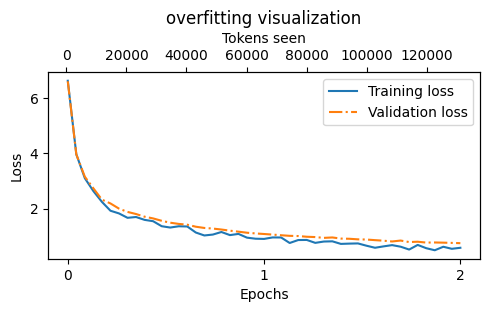

In [11]:
# losses
print(len(train_losses))
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

myllm.util.plot_learning_losses(num_epochs, token_seen, train_losses, val_losses )

## Extracting responses

In [17]:
torch.manual_seed(123)

for entry in test_data[:20]:
    input_text = data.format_instruction_input(entry)
    token_ids = model.generate(
        idx=myllm.util.text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=gpt_config["context_length"],
        eos_id=data.PAD_TOKEN_ID
    )
    generated_text = myllm.util.token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response: \n>> {entry['output']}")
    print(f"\nModel responde: \n>> {response_text.strip()}")
    print(f"-------------------")

Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: 
>> The car is as fast as lightning.

Model responde: 
>> 
-------------------
Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response: 
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model responde: 
>> What type of clouds?

What type of clouds?
What type of clouds?
What type of clouds?
What type of clouds?
-------------------
Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response: 
>> Jane Austen.

Model responde: 
>> Name'.
Name'.
Name'.
Name'.
Name'.
Name'.
Name'.
